<a href="https://colab.research.google.com/github/bharevmani/Data-Driven-simulation-of-a-portflio-allocation/blob/master/airbnb_prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/AB_NYC_2019.csv')

In [ ]:
#condensing dataset to the 5 features used in model
df_5 = df[['neighbourhood_group','room_type','number_of_reviews','reviews_per_month','availability_365']]
print(df_5.head())
print(df_5.shape)

  neighbourhood_group        room_type  ...  reviews_per_month  availability_365
0            Brooklyn     Private room  ...               0.21               365
1           Manhattan  Entire home/apt  ...               0.38               355
2           Manhattan     Private room  ...                NaN               365
3            Brooklyn  Entire home/apt  ...               4.64               194
4           Manhattan  Entire home/apt  ...               0.10                 0

[5 rows x 5 columns]
(48895, 5)


In [ ]:
#checking frequency of
# 1. Neighbourhood groups
# 2. Room types
top_neighbourhood_groups = df['neighbourhood_group'].value_counts()
print(top_neighbourhood_groups)
print()
print(df['room_type'].value_counts())
print("free Airbnb ", sum(df['price'] == 0))

Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: neighbourhood_group, dtype: int64

Entire home/apt    25409
Private room       22326
Shared room         1160
Name: room_type, dtype: int64
free Airbnb  11


Text(0.5, 0, 'Neighbourhood names')

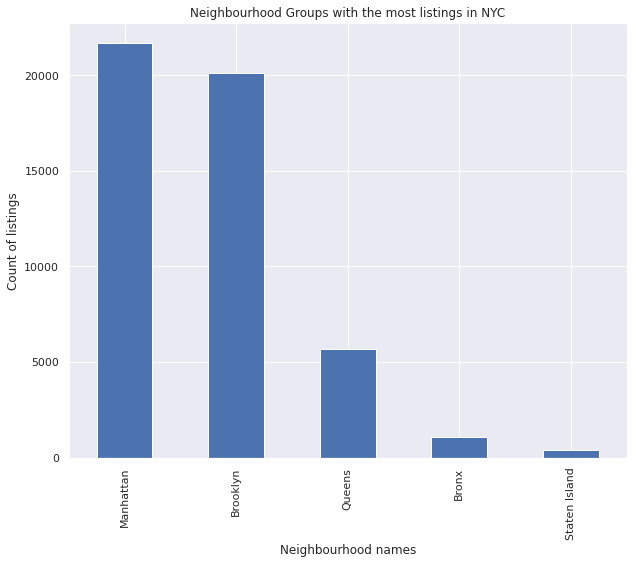

In [ ]:
#visualising frequency of rooms in each neighbourhood group
sns.set(rc={'figure.figsize':(10,8)})
vis_1 = top_neighbourhood_groups.plot(kind = 'bar')
vis_1.set_title("Neighbourhood Groups with the most listings in NYC")
vis_1.set_ylabel("Count of listings")
vis_1.set_xlabel("Neighbourhood names")

In [ ]:
#converting price to log price 
label = df['price'].copy()
eda_df = df.copy()
eda_label = pd.DataFrame(np.log(label.values), columns=['log price'])
eda_df.drop(columns=['price'],inplace=True)
eda_df = pd.concat([eda_df, eda_label], axis=1)
print(eda_df.head())

     id  ... log price
0  2539  ...  5.003946
1  2595  ...  5.416100
2  3647  ...  5.010635
3  3831  ...  4.488636
4  5022  ...  4.382027

[5 rows x 16 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


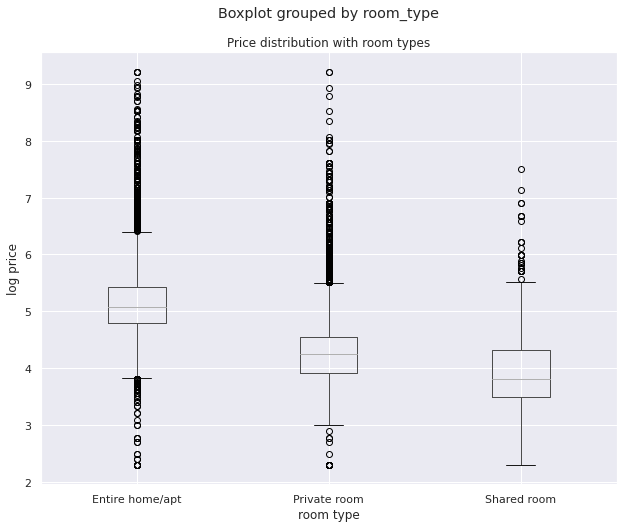

In [ ]:
#log price vs room type
eda_df[['log price','room_type']].boxplot(by='room_type')
plt.title('Price distribution with room types')
plt.ylabel('log price')
plt.xlabel("room type")
plt.show()

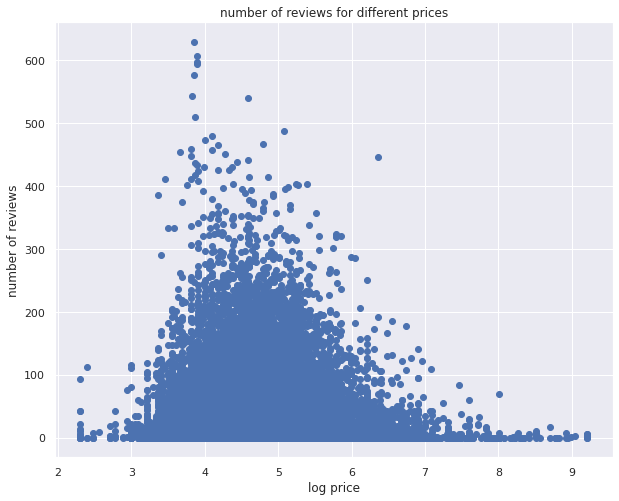

In [ ]:
#log price vs number of reviews
plt.scatter(eda_df['log price'],eda_df['number_of_reviews'])
plt.title("number of reviews for different prices")
plt.xlabel("log price")
plt.ylabel("number of reviews")
plt.show()

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


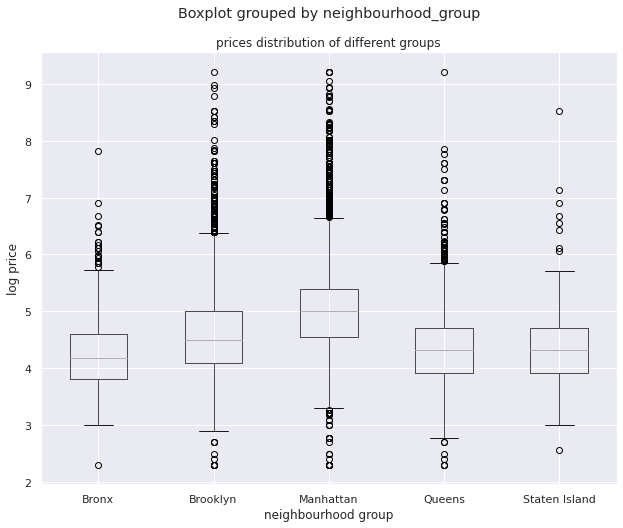

In [ ]:
#log price vs neighbourhood group
eda_df[['log price','neighbourhood_group']].boxplot(by='neighbourhood_group')
plt.xlabel("neighbourhood group")
plt.ylabel('log price')
plt.title("prices distribution of different groups")
plt.show()

Pre Processing

In [ ]:
cat_ftrs = ['neighbourhood_group']
ordinal_ftrs = ['room_type']
ordinal_cats = [['Entire home/apt','Private room','Shared room']]
num_ftrs = ['number_of_reviews', 'reviews_per_month']

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse=False))])

ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

numeric_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer(estimator=RandomForestRegressor(),random_state=3)),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs),
        ('num', numeric_transformer, num_ftrs)])

In [ ]:
X_prep = preprocessor.fit_transform(df_5)
feature_names = list(preprocessor.named_transformers_['cat'][0].get_feature_names()) +\
                preprocessor.transformers_[1][-1] +\
                preprocessor.transformers_[2][-1]
print(feature_names)

['x0_Bronx', 'x0_Brooklyn', 'x0_Manhattan', 'x0_Queens', 'x0_Staten Island', 'room_type', 'number_of_reviews', 'reviews_per_month']


In [ ]:
df_preprocessed = pd.DataFrame(data=X_prep,columns=feature_names)
label = df['price'].copy()
label[label <= 100] = 0
label[label > 100] = 1
price = pd.DataFrame(label, columns=['price'])
df1_preprocessed = pd.concat([df_preprocessed, price], axis=1) #pre processed dataset
print(df1_preprocessed.head())
print(len(df1_preprocessed)) 

   x0_Bronx  x0_Brooklyn  ...  reviews_per_month  price
0       0.0          1.0  ...          -0.600329      1
1       0.0          0.0  ...          -0.491493      1
2       0.0          0.0  ...          -0.557902      1
3       0.0          1.0  ...           2.235801      0
4       0.0          0.0  ...          -0.670752      0

[5 rows x 9 columns]
48895


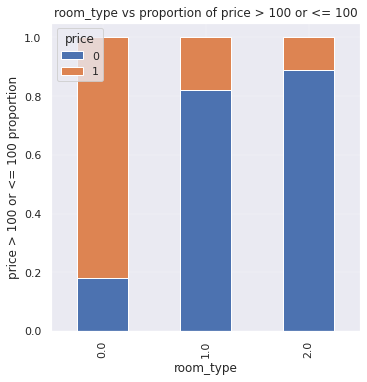

In [ ]:
plt.figure(figsize=(15,15))
eda_feature_names = ['room_type']

plot_number = 1
for col in eda_feature_names:
    count_matrix=df1_preprocessed.groupby([col,'price']).size().unstack()
    count_matrix_norm=count_matrix.div(count_matrix.sum(axis=1),axis=0)
    
    ax = plt.subplot(3, 3, plot_number)
    count_matrix_norm.plot(kind='bar', stacked=True, ax=ax)
    ax.grid(linewidth=0.25)
    ax.set_title(col + " vs proportion of price > 100 or <= 100")
    ax.set_ylabel("price > 100 or <= 100 proportion")
    plot_number = plot_number + 1
plt.tight_layout()

In [ ]:
y = df1_preprocessed['price']
print(y.value_counts()/y.shape)

1    0.510625
0    0.489375
Name: price, dtype: float64


In [ ]:
y = df1_preprocessed['price'].values
df1_preprocessed.drop(columns=['price'],inplace=True)
X = df1_preprocessed
print(X.head())

   x0_Bronx  x0_Brooklyn  ...  number_of_reviews  reviews_per_month
0       0.0          1.0  ...          -0.320414          -0.600329
1       0.0          0.0  ...           0.487665          -0.491493
2       0.0          0.0  ...          -0.522433          -0.557902
3       0.0          1.0  ...           5.538156           2.235801
4       0.0          0.0  ...          -0.320414          -0.670752

[5 rows x 8 columns]


In [ ]:
print(y)

[1 1 1 ... 1 0 0]


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer

In [ ]:
from sklearn.ensemble import RandomForestClassifier
def ML_pipeline_kfold_GridSearchCV_RF(X,y,random_state,n_folds):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state,stratify=y)
    # splitter for _other
    kf = StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # create the pipeline: supervised ML method
    pipe = make_pipeline(RandomForestClassifier(n_estimators =  100,random_state=random_state))
    # the parameter(s) we want to tune
    param_grid = {'randomforestclassifier__max_depth': [10,30,100,300],
                  'randomforestclassifier__min_samples_split': [16, 32, 64, 128]}
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid, scoring = make_scorer(accuracy_score),
                        cv=kf, return_train_score = True, iid=True, n_jobs=-1, verbose=10)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
    return grid, grid.score(X_test, y_test), X_test, y_test

In [ ]:
grid, score, X_test, y_test = ML_pipeline_kfold_GridSearchCV_RF(X,y,42,4)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:  2.0min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [ ]:
print("Best set of hyperparameters chosen by CV is ", grid.best_params_)
print("Best average score of all sets of folds of the best set of hyperparameter is ", grid.best_score_)
print("Use the best set of hyperparameter, we apply to test set, we get test score is ", score)

Best set of hyperparameters chosen by CV is  {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_split': 32}
Best average score of all sets of folds of the best set of hyperparameter is  0.8230136005726557
Use the best set of hyperparameter, we apply to test set, we get test score is  0.8201247571326311


In [ ]:
import pickle

filename = 'finalized_rf.sav'
pickle.dump(grid, open(filename, 'wb'))

In [ ]:
test_scores = []
for i in range(10):
    grid, test_score, X_test, y_test = ML_pipeline_kfold_GridSearchCV_RF(X,y,i*42,5)
    print(grid.best_params_)
    print('best CV score:',grid.best_score_)
    print('test score:',test_score)
    test_scores.append(test_score)
print('test accuracy:',np.around(np.mean(test_scores),4),'+/-',np.around(np.std(test_scores),4))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.6min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


{'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_split': 128}
best CV score: 0.8232436854484099
test score: 0.8198179772982923
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.5min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


{'randomforestclassifier__max_depth': 100, 'randomforestclassifier__min_samples_split': 128}
best CV score: 0.8228857756416812
test score: 0.8207383168013089
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.6min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


{'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_split': 16}
best CV score: 0.8228090806830964
test score: 0.8202270170774107
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.6min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


{'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_split': 16}
best CV score: 0.8230391655588506
test score: 0.8219654361386645
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.5min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


{'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_split': 64}
best CV score: 0.822655690765927
test score: 0.8237038551999182
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.6min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


{'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_split': 32}
best CV score: 0.8219910011248593
test score: 0.8217609162491052
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.6min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


{'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_split': 64}
best CV score: 0.8235249002965538
test score: 0.8194089375191738
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.5min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


{'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_split': 128}
best CV score: 0.8221699560282237
test score: 0.8212496165252071
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.6min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


{'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_split': 64}
best CV score: 0.8218631761938848
test score: 0.8256467941507312
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.5min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


{'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_split': 64}
best CV score: 0.8234226403517743
test score: 0.8189998977400552
test accuracy: 0.8214 +/- 0.0019
